# Solving our ice sheet model numercially

## Level 1: A working code with a few crucial lines removed.
This version of the code has a few lines missing that you will need to write in order to get the model running and plot the results. 

## The model

The ice-sheet model we have derived is defined by

$$
\frac{\partial H}{\partial t} = \dot{b_i}(x) - \frac{\partial q}{\partial x},
$$

$$
q = -\frac{2A}{n+2} \left(\rho g \alpha \right)^n  H^{n+2}  
$$

where $\dot{b_i}$ is the ice-equivalent rate of accumulation on the ice sheet surface, $x$ is the horizontal coordinate, $H$ is the ice thickness, $t$ is time, $q$ is the depth-intergrated flux per unit width (hereafter, flux), $A$ is the flow parameter from the flow law, $n$ is the exponent from the flow law, $\rho$ is the density of ice, $g$ is acceleration due to gravity, and $\alpha$ is the surface slope $\left(= - \frac{\partial H}{\partial x}\right)$.

We will use a a simple finite-difference scheme. It approximates the derivatives as differences, e.g.

$$
\frac{\partial H}{\partial t} = \frac{H^{j+1}-H^{j}}{\Delta t}
$$

where $j$ refers to which 'time step' we are looking at and $\Delta t$ is the time interval between timesteps. 

Applying this approximation (or more precisly a 'centered-difference version of the approximation) to the spatial derivatives gives

$$
\frac{\partial q}{\partial x}\bigg\rvert^j = \frac{ q^j_{i+1} - q^j_{i-1}}{2 \Delta x}
$$ 

and

$$
\frac{\partial H}{\partial x}\bigg\rvert^j = \frac{ H^j_{i+1} - H^j_{i-1}}{2 \Delta x}.
$$



Substituting these into our model gives

$$
\frac{H^{j+1}-H^{j}}{\delta t} = a_i - \frac{\partial q^j_{i+1} - q^j_{i-1}}{2 \Delta x},
$$


$$
q^j_i = -\frac{2A}{n+2} \left(\rho g  \right)^n  {H^j_i}^{n+2}  \left(\frac{H^j_{i+1} - H^j_{i-1}}{2\Delta x}\right)^n
$$



We impose the surface mass balance (SMB) as a simple linear function of distance:

$$
a = 10^{-4}\left(\frac{X}{3}-x\right), 
$$

where $X$ is the length of the spatial domain. 

We will also impose a no-flow boundary condition on the right hand side. Let's think about what this looks like in our model as we go along.

We will also assume a flat bed topography.

## Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

## 1. Set up time and space grids
The first step is to set up our descritized time and space domains. We will use units of years for time and meters for distance. Setting up the grid involves choosing a time step, a total number of years the simulation should last, a grid spacing and a domain length:

In [2]:
# time domain
dt = 0.004                        # time step, units [years]
T = 3000                          # total length of simulation, units [years]
t = np.linspace(0,T,round(T/dt))  # the time grid, units [years]
Lt = t.size                       # record the length of the time grid for use later

In [3]:
# space domain
dx = 200                          # grid spacing, units [m]
X = 40000                         # domain length, units [m]
x = np.linspace(0,X,round(X/dx))  # spatial grid, units [m]
Lx = x.size                       # record the length of the spatial grid for use later

The numerical scheme is a more stable if we evaluate the flux $q$ on a staggered grid. This is a grid of points that lie at the midpoints of all the normal grid points. This will allow us to easily evaluate the gradient of $q$ back on the normal grid to evolve $H$ forward in time. 

In [4]:
x_stag = x[0:-1] + 0.5*dx

Note that the staggered grid has one less element that the normal grid:


In [5]:
print(f'The staggered grid has {x_stag.size} elements,')
print(f'whereas the normal grid has {Lx} elements.')

The staggered grid has 199 elements,
whereas the normal grid has 200 elements.


## 2. Define physical constants
These are the parameters that we will not be varying in our model - at least not initially.

We include a small numerical parameter `e`. In places where $H = 0$, the physics that our model describes do not apply, so a simple (but crude) way to avoid this is to never allow $H$ to go below this small value `e`.

In [15]:
n = 3.0                              # The flow law exponent
seconds_per_year = 365*24*60*60      # approximate number of seconds in year
A = 24*10**(-25) * seconds_per_year  # The flow law parameter, units [Pa a] (original value from Cuffey and Paterson 24e-25, units Pa s]
rho = 917                            # ice density,  units [kg/m^3]
g = 10                               # acceleration due to gravity, units [m/s^2]
e = 0.0001                           # used to prevent ice thickness from reaching zero

## 3. Preallocate the ice thickness array
For simplicity, we will save the ice thickness at every time step. To do this most efficiently, we 'pre-allocate' the memory for the array by creating an array the right width and height consisting of zeros. Notice that the time domain will correspond to the first index of `H` and the spatial domain will correspond to the second. 

In [16]:
H = np.zeros((Lt,Lx))

## 4. Define initial conditions
Because our model contains a time derivative of ice thickness $H$, we need to assign $H$ an initial condition. This will be arbitrary, so we better make sure that the conclusions we draw from simulations do not rely on this arbitrary choice. 

For simicity we will make $H$ uniform initally and equal to `e`.

In [17]:
H[0,:] = e

## 5. Prescribe the surface mass balance
The model is forced by the surface mass balance $\dot{b_i}$. For simplicity, we will prescribe $\dot{b_i}$ as a simple linear function of distance. 

$$
\dot{b_i} = 10^{-4} \left( \frac{X}{3} - x \right)
$$

In [18]:
MISSING CODE HERE!!!

Let's plot the surface mass balance as a function of $x$:

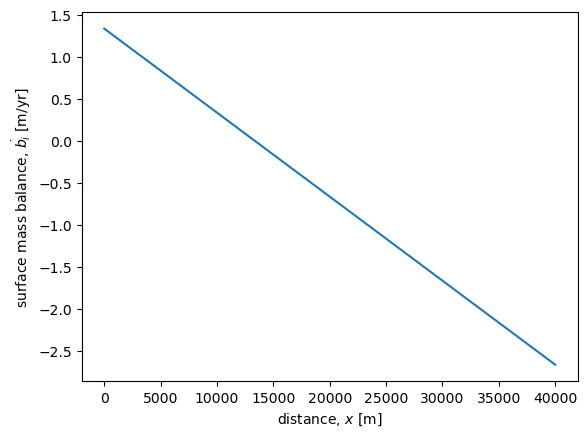

In [19]:
plt.figure()
plt.plot(x,b);
plt.xlabel('distance, $x$ [m]')
plt.ylabel('surface mass balance, $\dot{b_i}$ [m/yr]')
plt.show()

This function says that $\dot{b_i}$ is positive on the left of our model domain and decreases linearly with $x$, passing zero at $x=1500$ m. This is probably not how SMB really works; $\dot{b_i}$ is more likely to be a function of elevation $\left(\dot{b_i}(H)\right)$ rather than distance $\left(\dot{b_i}(x)\right)$, but with a flat bed like this, $\dot{b_i}(H)$ leads to unstable ice sheet growth or decay, so the only steady state we can reach is $H(x) = 0$, which isn't very interesting. So we will stick with this unrealistic way of imposing $\dot{b_i}$ for now and we can always come back to this later and look at what happens when it is prescribed in a more realistic way. 


## 6. Prepare for plotting
The simulation (below) will involve iteratively solving the model equations at each time step. This will happen in a for loop.

To track the progress of  simulations we will want to print a message from within our for loop, but not in every iteration because there will be len(t) iterations, which is thousands. The simplest solution is to only print a message whenever the remainder of dividing the iteration number by some large number `print_period` is zero. 

Note that a nicer solution would be to use a package which will print a progress bar like [tqdm](https://tqdm.github.io/), but this requires installing a new package, so we won't do that right now. 

In [20]:
print_period = 30000

## 7. Run the simulation
Finally, we are ready to run our simulation. 

We will loop through every time step. In each iteration, $j$ we will use the ice thickness from the previous time, $H^{j-1}$ step to compute the following:

1. the ice thickness on the staggered grid,
2. the surface slope, $\alpha$, on the staggered grid, using (1) 
3. the flux on the staggered grid, using (1) and (2), and 
4. the ice thickness at the current time step on the normal grid, using (3) and $\dot{b_i}$ 

The code in cell below is numbered to show where each step is happening. 

The code in the cell below also times the executiono the model with `%%time` and applies the boundary conditions. 

In [24]:
%%time   

for timestep in np.arange(1,Lt):
    
    # only print a message when the remainder of the timestep number and `print_period` is zero. i.e. if print_period = 30000, this prints a message very 30,000th timestep.
    if timestep % print_period == 0:    
        print(f'{t[timestep]:.1f} out of {T} years')

    # save the old thickness vector
    H_old  = H[timestep-1,:]
    
    # (1) compute H on the staggered grid
    H_stag = (H_old[1:] + H_old[:-1])/2
    
    # (2) compute the surface slope on the staggered grid.
    alpha = -(H_old[1:] - H_old[:-1])/dx 
    
    # (3) compute the flux on the staggered grid
    q = 2*A/(n+2) * (rho * g * alpha)**n * H_stag**(n+2)  
    
    # (4) compute the ice thickness at the current time step
    MISSING CODE HERE!!!   

    # apply the boundary conditions at x = 0 and x = X
    H[timestep,0] = H[timestep,1]
    H[timestep,-1] = e

120.0 out of 3000 years
240.0 out of 3000 years
360.0 out of 3000 years
480.0 out of 3000 years
600.0 out of 3000 years
720.0 out of 3000 years
840.0 out of 3000 years
960.0 out of 3000 years
1080.0 out of 3000 years
1200.0 out of 3000 years
1320.0 out of 3000 years
1440.0 out of 3000 years
1560.0 out of 3000 years
1680.0 out of 3000 years
1800.0 out of 3000 years
1920.0 out of 3000 years
2040.0 out of 3000 years
2160.0 out of 3000 years
2280.0 out of 3000 years
2400.0 out of 3000 years
2520.0 out of 3000 years
2640.0 out of 3000 years
2760.0 out of 3000 years
2880.0 out of 3000 years
CPU times: user 33.6 s, sys: 948 ms, total: 34.6 s
Wall time: 35.3 s


## 8. Plot the results
The simplest result to plot is the final ice thickness, $H(x,T)$:

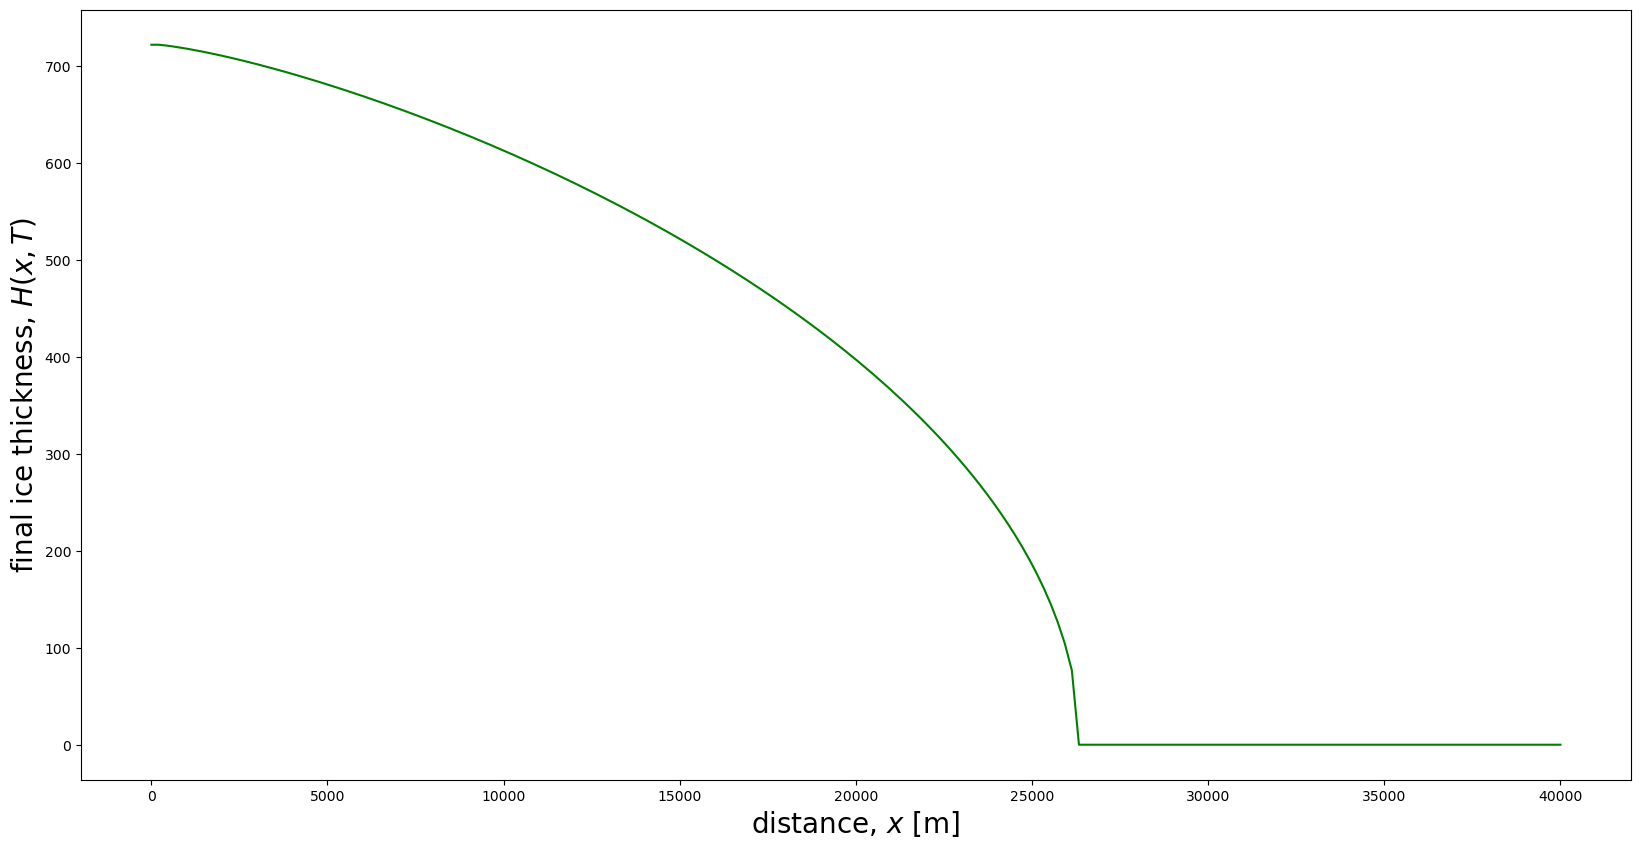

In [26]:
plt.figure(figsize=(20, 10))
MISSING CODE HERE!!!
plt.xlabel('distance, $x$ [m]', size = 20)
plt.ylabel('final ice thickness, $H(x,T)$', size = 20)
plt.show()


We can also plot the thickness profile $H(x)$ from every 10,000th timestep. We see that the glacier grows from the initial conditions of $H(t=0,x) = e$ and advances until we get a characteristic convex ice-sheet shape. This is caused by the interplay of thinning towards the terminus, the dependence of flux on thickness, and the spatial variability of flux. 

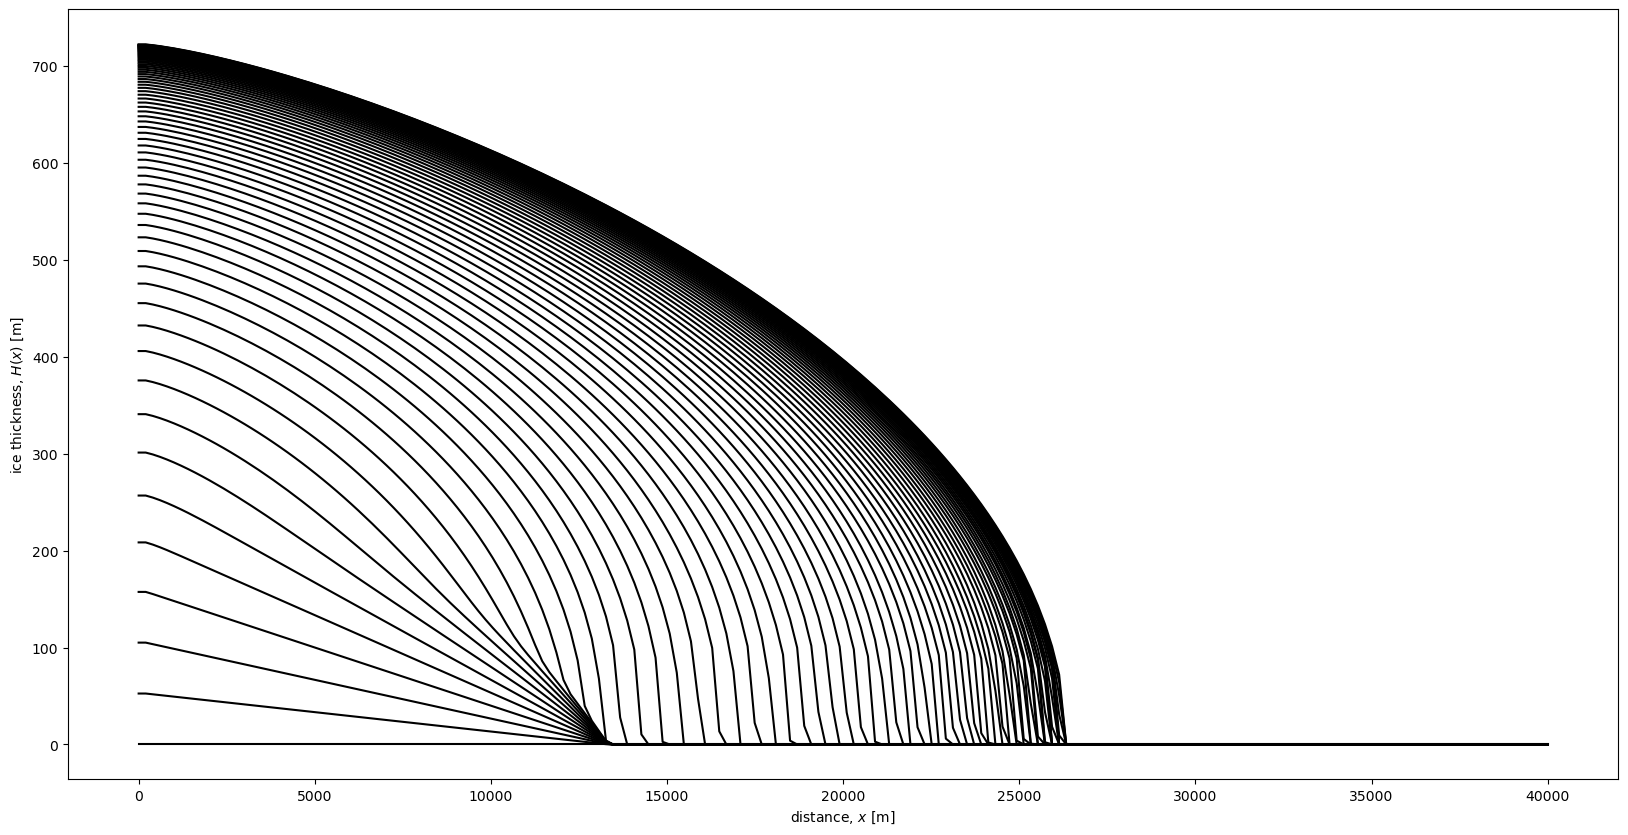

In [27]:
plt.figure(figsize=(20, 10))
MISSING CODE HERE!!!
plt.xlabel('distance, $x$ [m]')
plt.ylabel('ice thickness, $H(x)$ [m]')
plt.show()


Another kind of plot we can make is a time series of ice thickness from a particualr location. In this case we will plot the icce thickness on the left side of the domain - the ice divide. 

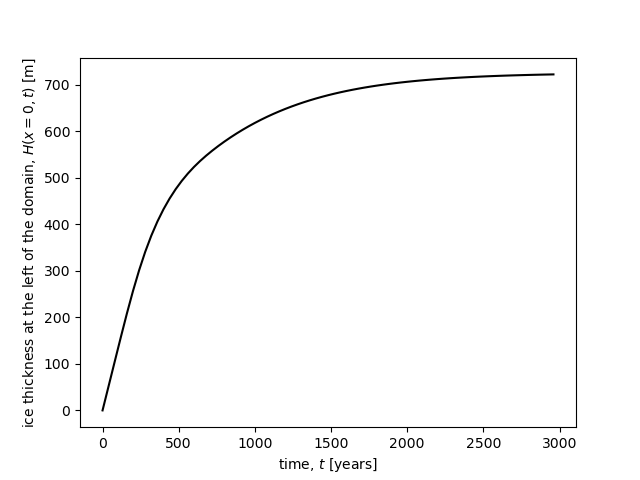

In [31]:
plt.figure()
MISSING CODE HERE!!!
plt.xlabel('time, $t$ [years]')
plt.ylabel('ice thickness at the left of the domain, $H(x=0,t)$ [m]')
plt.show()

We can also plot the final ice flux as follows.

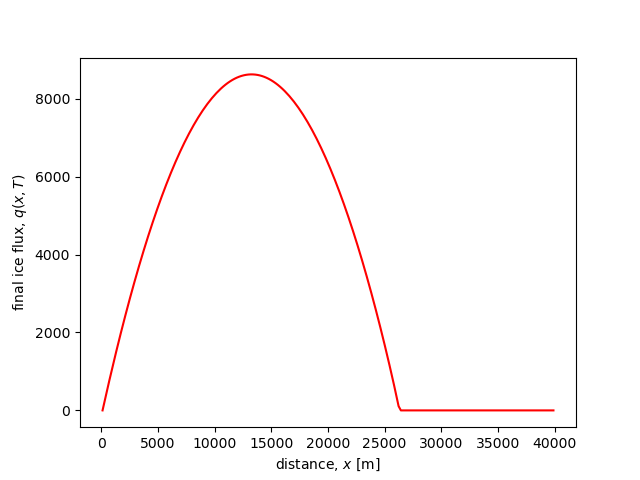

In [33]:
plt.figure()
MISSING CODE HERE!!!
plt.xlabel('distance, $x$ [m]', size = 10)
plt.ylabel('final ice flux, $q(x,T)$', size = 10)
plt.show()